In [1]:
import random
import pandas as pd
import numpy as np
from Time_MoE.time_moe.datasets.time_moe_dataset import TimeMoEDataset

# Importing custom functions
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

from baseline.functions import load_data,create_intervals,create_windows,smape,smape_chunked,sample_fraction
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler , RobustScaler
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os


def load_data_clean():
    ds = TimeMoEDataset('Time-300B\healthcare',normalization_method='zero')

    verbose = True
    total = len(ds)
    valid_indices = []
    # Iterar y filtrar
    for i in range(total):
        try:
            seq = ds[i]  # seq es numpy.ndarray según comprobaste
        except Exception as e:
            # Si hay error al obtener la secuencia, lo avisamos y saltamos
            if verbose:
                print(f"Advertencia: no se pudo obtener ds[{i}]: {e}")
            continue
        
        # Comprobación: si todos los valores son NaN, lo descartamos
        # seq es numpy.ndarray; cuidado si dims especiales, pero np.isnan funcionará elementwise.
        try:
            if not np.all(np.isnan(seq)):
                valid_indices.append(i)
        except Exception as e:
            # En caso de que seq no sea array puro, convertir primero:
            try:
                arr = np.array(seq)
                if not np.all(np.isnan(arr)):
                    valid_indices.append(i)
            except Exception as e2:
                if verbose:
                    print(f"Error al verificar NaN en secuencia índice {i}: {e2}")
                # Decidir si incluirla o no. Aquí optamos por descartarla:
                continue
    
    valid_count = len(valid_indices)
    if verbose:
        print(f"Secuencias totales en ds: {total}")
        print(f"Secuencias válidas (no todo NaN): {valid_count}")
        print(f"Secuencias descartadas: {total - valid_count}")
        sequences_validas = []

    for idx in valid_indices:
        try:
            sequences_validas.append(ds[idx])
        except Exception as e:
            if verbose:
                print(f"Error al extraer ds[{idx}] después de filtrar: {e}")
            # Podrías decidir saltar o detener. Aquí solo saltamos.
    return sequences_validas

def create_windows_from_sequences(sequences, window_size=15, horizon=1):
    """
    Dada una lista de secuencias (numpy arrays 1D), crea ventanas deslizantes:
    - X: array de shape (num_samples, window_size, 1)
    - y: array de shape (num_samples,)
    Cada muestra usa window_size pasos para predecir el siguiente valor (horizon=1).
    """
    X_list = []
    y_list = []
    for seq in sequences:
        # Asegurar numpy array
        arr = np.array(seq).astype(float)
        T = arr.shape[0]
        # Solo si la longitud es mayor que window_size + horizon - 1
        if T >= window_size + horizon:
            for start in range(0, T - window_size - horizon + 1):
                window = arr[start:start+window_size]
                target = arr[start+window_size:start+window_size+horizon]
                # Para horizon=1, target es un array de longitud 1; tomamos el escalar
                X_list.append(window.reshape(window_size, 1))
                y_list.append(target[0] if horizon == 1 else target)
    if len(X_list) == 0:
        return np.empty((0, window_size, 1)), np.empty((0,))
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)

    # Supongamos X tiene forma (N, window_size, 1), y y forma (N,)
    mask_valid = ~np.isnan(X).any(axis=(1,2)) & ~np.isnan(y)
    # Mantener solo muestras sin NaN:
    X_clean = X[mask_valid]
    y_clean = y[mask_valid]
    print("De", X.shape[0], "muestras, quedan", X_clean.shape[0], "sin NaN")

    return X_clean, y_clean

In [2]:
ds = load_data_clean()
X, y = create_windows_from_sequences(ds, window_size=15, horizon=1)

Secuencias totales en ds: 1752
Secuencias válidas (no todo NaN): 1752
Secuencias descartadas: 0
De 433317 muestras, quedan 433317 sin NaN


### Neural - 100 %

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [9]:
# Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x):
        return self.net(x)

class NeuralODEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = ODEFunc()
    
    def forward(self, x):
        # x: [batch_size, seq_len, features]
        device = x.device
        seq_len = x.shape[1]
        # Crear t en el dispositivo correcto
        t = torch.linspace(0, 1, seq_len, device=device)
        # Estado inicial para cada muestra: último valor de la secuencia
        # Si features=1, x[:, -1, :] es [batch_size, 1]
        y0 = x[:, -1, :]
        # Integrar en batch: devuelve [len(t), batch_size, features]
        out = odeint(self.odefunc, y0, t, method='rk4')
        # Tomar el valor final en t=1 para cada muestra
        y_final = out[-1]
        return y_final  # forma [batch_size, features]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Usa DataLoader para evitar cargar todo en la GPU al mismo tiempo
def train_model(model, X_train, y_train, X_test, y_test, batch_size=64, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_vals = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        loss_vals.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    best_epoch = int(np.argmin(loss_vals)) + 1
    best_loss = loss_vals[best_epoch - 1]
    print(f"Mejor época = {best_epoch}, Loss = {best_loss:.4f}")

    # Evaluación
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy()

    y_test_inv = y_test_tensor.cpu().numpy().reshape(-1, 1)
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    smape_value = smape(y_test_inv, y_pred)
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, sMAPE: {smape_value:.4f}")

    return model, loss_vals

In [11]:
model = NeuralODEModel()
trained_model, loss_vals = train_model(model, X_train, y_train, X_test, y_test)

c:\Users\criju\.conda\envs\cuda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\criju\.conda\envs\cuda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 1.0156
Epoch 2/20, Loss: 1.0037
Epoch 3/20, Loss: 1.0035
Epoch 4/20, Loss: 1.0034
Epoch 5/20, Loss: 1.0035
Epoch 6/20, Loss: 1.0034
Epoch 7/20, Loss: 1.0034


KeyboardInterrupt: 

In [16]:
# Supongamos que tu modelo ya ha sido entrenado
torch.save(model.state_dict(), "Models_neural/modelo_100.pth")

### Neural - 10 %

In [17]:
# function to take only a percentage of the data
X_10, y_10 = sample_fraction(X, y, 0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_10, y_10, test_size=0.2, shuffle=True, random_state=42)

In [18]:
model = NeuralODEModel()
trained_model, loss_vals = train_model(model, X_train, y_train, X_val, y_val)

c:\Users\criju\.conda\envs\cuda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\criju\.conda\envs\cuda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 1.1121
Epoch 2/20, Loss: 0.9849
Epoch 3/20, Loss: 0.9803
Epoch 4/20, Loss: 0.9787
Epoch 5/20, Loss: 0.9782
Epoch 6/20, Loss: 0.9779
Epoch 7/20, Loss: 0.9773
Epoch 8/20, Loss: 0.9775
Epoch 9/20, Loss: 0.9772
Epoch 10/20, Loss: 0.9771
Epoch 11/20, Loss: 0.9770
Epoch 12/20, Loss: 0.9771
Epoch 13/20, Loss: 0.9771
Epoch 14/20, Loss: 0.9770
Epoch 15/20, Loss: 0.9767
Epoch 16/20, Loss: 0.9767
Epoch 17/20, Loss: 0.9768
Epoch 18/20, Loss: 0.9768
Epoch 19/20, Loss: 0.9767
Epoch 20/20, Loss: 0.9767
Mejor época = 15, Loss = 0.9767
MAE: 0.7131, MSE: 0.9639, sMAPE: 97.2977


In [19]:
# Supongamos que tu modelo ya ha sido entrenado
torch.save(model.state_dict(), "Models_neural/modelo_10.pth")

### Neural - 3 %

In [5]:
# function to take only a percentage of the data
X_3, y_3 = sample_fraction(X, y, 0.03, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_3, y_3, test_size=0.2, shuffle=True, random_state=42)

In [6]:
model = NeuralODEModel()
trained_model, loss_vals = train_model(model, X_train, y_train, X_val, y_val)
torch.save(model.state_dict(), "Models_neural/modelo_3.pth")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

c:\Users\criju\.conda\envs\cuda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\criju\.conda\envs\cuda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 1.3428
Epoch 2/20, Loss: 1.0278
Epoch 3/20, Loss: 0.9995
Epoch 4/20, Loss: 0.9894
Epoch 5/20, Loss: 0.9855
Epoch 6/20, Loss: 0.9827
Epoch 7/20, Loss: 0.9812
Epoch 8/20, Loss: 0.9795
Epoch 9/20, Loss: 0.9788
Epoch 10/20, Loss: 0.9785
Epoch 11/20, Loss: 0.9778
Epoch 12/20, Loss: 0.9780
Epoch 13/20, Loss: 0.9772
Epoch 14/20, Loss: 0.9774
Epoch 15/20, Loss: 0.9766
Epoch 16/20, Loss: 0.9764
Epoch 17/20, Loss: 0.9761
Epoch 18/20, Loss: 0.9767
Epoch 19/20, Loss: 0.9760
Epoch 20/20, Loss: 0.9763
Mejor época = 19, Loss = 0.9760
MAE: 0.7116, MSE: 0.9600, sMAPE: 98.7690


# Neural Destilado

In [3]:
# function to take only a percentage of the data
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


X_3, y_3 = sample_fraction(X, y, 0.03, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_3, y_3, test_size=0.2, shuffle=True, random_state=42)

In [4]:
# Load teacher predictions
import csv

# Leer validación
r_t_val = []
with open('teacher_results/val_teacher.csv', newline='') as archivo:
    lector = csv.reader(archivo)
    for fila in lector:
        # Si tus datos eran numéricos, conviértelos, por ejemplo, a float:
        fila_convertida = [float(x) for x in fila]
        r_t_val.append(fila_convertida)

# Leer entrenamiento
r_t_train = []
with open('teacher_results/train_teacher.csv', newline='') as archivo:
    lector = csv.reader(archivo)
    for fila in lector:
        fila_convertida = [float(x) for x in fila]
        r_t_train.append(fila_convertida)

In [ ]:
class StudentODE(nn.Module):
    def __init__(self):
        super().__init__()
        # tu ODE backbone
        self.backbone = NeuralODEModel()
        # dos salidas
        self.head_clean   = nn.Linear(1, 1)    # Rs
        self.head_distill = nn.Linear(1, 1)    # Rd

    def forward(self, x):
        # x: [batch, seq_len, feat=1]
        h = self.backbone(x)                   # [batch,1]
        Rs = self.head_clean(h)                # [batch,1]
        Rd = self.head_distill(h)              # [batch,1]
        return Rs, Rd
    
def train_student_ode(
    model, X_train, y_train, r_t_train,
    X_val,   y_val,   r_t_val,
    batch_size=64, epochs=20, lr=0.001
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device)

    # DataLoaders que entregan (Xb, tb, rtb)
    train_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.reshape(-1,1), dtype=torch.float32),
        torch.tensor(r_t_train,    dtype=torch.float32)
    )
    val_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val.reshape(-1,1), dtype=torch.float32),
        torch.tensor(r_t_val,    dtype=torch.float32)
    )
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_size)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Pre‑calcula epsilon con clamp para no obtener nan
    # 1) Calcula xi
    xi  = y_train.reshape(-1,1) - r_t_train

    mad   = np.median(np.abs(xi - np.median(xi)))
    sigma = 1.4826 * mad

    # 2) elige tu alpha
    alpha = 1.0

    # 3) evita nan clippeando el ratio a <1
    ratio = alpha / (np.sqrt(2*np.pi) * sigma)
    ratio = min(ratio, 1 - 1e-6)

    # 4) calcula epsilon sin miedo a nan
    epsilon = sigma * np.sqrt(-2.0 * np.log(ratio))

    for epoch in range(1, epochs+1):
        model.train()
        tot_loss = 0.0

        for Xb, tb, rtb in train_loader:
            Xb, tb, rtb = Xb.to(device), tb.to(device), rtb.to(device)
            optimizer.zero_grad()

            Rs, Rd = model(Xb)  # ambas de shape (B,1)

            # TOR loss:
            err      = torch.abs(tb - rtb)
            loss_c   = (Rs - tb).pow(2)
            loss_o   = torch.sqrt((Rs - rtb).pow(2) + 1e-6)
            L_tor    = torch.where(err < epsilon, loss_c, loss_o).mean()

            # Distillation loss (L1):
            L_dist   = torch.abs(Rd - rtb).mean()

            loss = L_tor + L_dist
            loss.backward()
            optimizer.step()
            tot_loss += loss.item() * Xb.size(0)



        tot_loss /= len(train_ds)
        print(f"Epoch {epoch}/{epochs} — Train Loss: {tot_loss:.4f}")
    return model

In [36]:
student = StudentODE()

student_trained = train_student_ode(
    student,
    X_train, y_train, r_t_train,
    X_val,   y_val,   r_t_val,
    batch_size=64,
    epochs=20,
    lr=0.001
)


Epoch 1/20 — Train Loss: 1.4214
Epoch 2/20 — Train Loss: 1.0923
Epoch 3/20 — Train Loss: 0.8801
Epoch 4/20 — Train Loss: 0.7240
Epoch 5/20 — Train Loss: 0.5714
Epoch 6/20 — Train Loss: 0.4093
Epoch 7/20 — Train Loss: 0.3429
Epoch 8/20 — Train Loss: 0.3359
Epoch 9/20 — Train Loss: 0.3349
Epoch 10/20 — Train Loss: 0.3333
Epoch 11/20 — Train Loss: 0.3328
Epoch 12/20 — Train Loss: 0.3321
Epoch 13/20 — Train Loss: 0.3315
Epoch 14/20 — Train Loss: 0.3309
Epoch 15/20 — Train Loss: 0.3302
Epoch 16/20 — Train Loss: 0.3306
Epoch 17/20 — Train Loss: 0.3299
Epoch 18/20 — Train Loss: 0.3298
Epoch 19/20 — Train Loss: 0.3295
Epoch 20/20 — Train Loss: 0.3291


## Resultados de modelo Neural Destilado 3% sobre el conjunto de validación

In [37]:
student.eval()
x_neural = torch.tensor(X_val, dtype=torch.float32)
Rs_pred, Rd_pred = student(torch.tensor(X_val, dtype=torch.float32).to(device))
# Rd_pred es tu salida distill, compárala con y_val:
results =  Rd_pred.cpu().detach().numpy().flatten()


In [38]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, results)
mae = mean_absolute_error(y_val, results)
smape_val = smape(y_val, results)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 0.3117070048714903
MSE: 0.3285529347478569
SMAPE: 28.30021689940347


In [39]:
torch.save(student.state_dict(), "Models_neural/modelo_3_dest.pth")

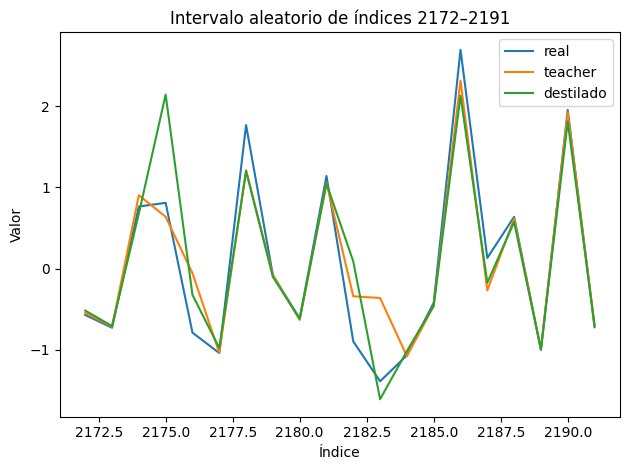

In [40]:
import random
import matplotlib.pyplot as plt

# Tus listas originales:
# y_val, r_t_val, Rd_output

# Asegúrate de que todas tengan la misma longitud n ≥ 20
n = len(y_val)

# Elige un índice de inicio aleatorio tal que haya espacio para 20 puntos
inicio = random.randint(0, n - 20)
fin = inicio + 20

# Crea un eje X con los índices reales para ese intervalo
x = list(range(inicio, fin))

# Extrae los subrangos de cada serie
y_segmento     = y_val[inicio:fin]
teacher_segmento = r_t_val[inicio:fin]
destilado_segmento =  results[inicio:fin]

# Grafica solo el intervalo seleccionado
plt.figure()
plt.plot(x, y_segmento,         label='real')
plt.plot(x, teacher_segmento,   label='teacher')
plt.plot(x, destilado_segmento, label='destilado')

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title(f'Intervalo aleatorio de índices {inicio}–{fin-1}')
plt.legend()
plt.tight_layout()
plt.show()


### Neural Destilado - New Loss functions

In [5]:
from scipy.stats import norm
import numpy as np

def kl_normals(mu0, sigma0, mu1, sigma1):
    return ( np.log(sigma1/sigma0)
           + (sigma0**2 + (mu0-mu1)**2) / (2*sigma1**2)
           - 0.5 )

In [6]:
def kl_normals_torch(mu0, sigma0, mu1, sigma1):
    """
    KL(N(mu0, sigma0^2) || N(mu1, sigma1^2))
    = log(sigma1/sigma0)
    + [sigma0^2 + (mu0 - mu1)^2] / (2 * sigma1^2)
    - 0.5
    Todas las operaciones son torch ops, para conservar gradientes.
    """
    return (
        torch.log(sigma1 / sigma0)
        + (sigma0**2 + (mu0 - mu1)**2) / (2 * sigma1**2)
        - 0.5
    )

class New_loss(nn.Module):
    def __init__(self):
        super(New_loss, self).__init__()
    def forward(self, pred ,teacher , target ):

        resta_1 = pred - target
        resta_2 = teacher - target
        # KL
        mu0     = resta_1.mean()
        sigma0  = resta_1.std(unbiased=False)

        mu1     = resta_2.mean()
        sigma1  = resta_2.std(unbiased=False)

        # KL con torch ops
        kl_value = kl_normals_torch(mu0, sigma0, mu1, sigma1)
        return kl_value


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

def kl_normals_torch(mu0, sigma0, mu1, sigma1):
    """
    KL(N(mu0, sigma0^2) || N(mu1, sigma1^2))
    = log(sigma1/sigma0)
      + [sigma0^2 + (mu0 - mu1)^2] / (2 * sigma1^2)
      - 0.5
    Todas las operaciones son torch ops, para conservar gradientes.
    """
    return (
        torch.log(sigma1 / sigma0)
        + (sigma0**2 + (mu0 - mu1)**2) / (2 * sigma1**2)
        - 0.5
    )

class StudentODE_new(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone     = NeuralODEModel()
        self.head_clean   = nn.Linear(1, 1)  # Rs
        self.head_distill = nn.Linear(1, 1)  # Rd

    def forward(self, x):
        h  = self.backbone(x)    # [batch,1]
        Rs = self.head_clean(h)   # [batch,1]
        Rd = self.head_distill(h) # [batch,1]
        return Rs, Rd

def train_student_ode(
    model, X_train, y_train, r_t_train,
    X_val,   y_val,   r_t_val,
    batch_size=64, epochs=20, lr=1e-3
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device)

    # DataLoaders
    train_ds = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.reshape(-1,1), dtype=torch.float32),
        torch.tensor(r_t_train,    dtype=torch.float32),
    )
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterio = New_loss()

    for epoch in range(1, epochs+1):
        model.train()
        tot_loss = 0.0

        for Xb, tb, rtb in train_loader:
            Xb, tb, rtb = Xb.to(device), tb.to(device), rtb.to(device)
            optimizer.zero_grad()

            Rs, Rd = model(Xb)  # Rs: [B,1]

            # KL
            # resta_1 = tb - rtb
            # mu0     = resta_1.mean()
            # sigma0  = resta_1.std(unbiased=False)

            # resta_2 = Rs - rtb
            # mu1     = resta_2.mean()
            # sigma1  = resta_2.std(unbiased=False)

            # # KL con torch ops
            # kl_value = kl_normals_torch(mu0, sigma0, mu1, sigma1)

            # loss = kl_value

            loss = criterio(Rs, rtb, tb)  # Usando la nueva función de pérdida

            # MSE loss
            #loss = F.mse_loss(Rs, Rd)

            loss.backward()
            optimizer.step()

            tot_loss += loss.item() * Xb.size(0)

        tot_loss /= len(train_ds)
        print(f"Epoch {epoch}/{epochs} — Train Loss: {tot_loss:.6f}")

    return model


In [10]:
# Con KL
student = StudentODE_new()

student_trained = train_student_ode(
    student,
    X_train, y_train, r_t_train,
    X_val,   y_val,   r_t_val,
    batch_size=128,
    epochs=20,
    lr=0.001
)


Epoch 1/20 — Train Loss: 0.144984
Epoch 2/20 — Train Loss: 0.022031
Epoch 3/20 — Train Loss: 0.019824
Epoch 4/20 — Train Loss: 0.018989
Epoch 5/20 — Train Loss: 0.014677
Epoch 6/20 — Train Loss: 0.018408
Epoch 7/20 — Train Loss: 0.019959
Epoch 8/20 — Train Loss: 0.019696
Epoch 9/20 — Train Loss: 0.017644
Epoch 10/20 — Train Loss: 0.017565
Epoch 11/20 — Train Loss: 0.016296
Epoch 12/20 — Train Loss: 0.017638
Epoch 13/20 — Train Loss: 0.015147
Epoch 14/20 — Train Loss: 0.016781
Epoch 15/20 — Train Loss: 0.017713
Epoch 16/20 — Train Loss: 0.015870
Epoch 17/20 — Train Loss: 0.014353
Epoch 18/20 — Train Loss: 0.015353
Epoch 19/20 — Train Loss: 0.013176
Epoch 20/20 — Train Loss: 0.016500


In [41]:
# Con KL
student = StudentODE_new()

student_trained = train_student_ode(
    student,
    X_train, y_train, r_t_train,
    X_val,   y_val,   r_t_val,
    batch_size=128,
    epochs=20,
    lr=0.001
)


Epoch 1/20 — Train Loss: 0.405739
Epoch 2/20 — Train Loss: 0.036526
Epoch 3/20 — Train Loss: 0.052913
Epoch 4/20 — Train Loss: 0.048880
Epoch 5/20 — Train Loss: 0.043042
Epoch 6/20 — Train Loss: 0.034713
Epoch 7/20 — Train Loss: 0.035089
Epoch 8/20 — Train Loss: 0.044726
Epoch 9/20 — Train Loss: 0.044760
Epoch 10/20 — Train Loss: 0.048771
Epoch 11/20 — Train Loss: 0.034001
Epoch 12/20 — Train Loss: 0.038847
Epoch 13/20 — Train Loss: 0.039109
Epoch 14/20 — Train Loss: 0.043084
Epoch 15/20 — Train Loss: 0.048568
Epoch 16/20 — Train Loss: 0.044055
Epoch 17/20 — Train Loss: 0.039178
Epoch 18/20 — Train Loss: 0.034713
Epoch 19/20 — Train Loss: 0.041969
Epoch 20/20 — Train Loss: 0.034111


In [12]:
student_trained.eval()
x_neural = torch.tensor(X_val, dtype=torch.float32)
Rs_pred,Rd_pred= student_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
# Rd_pred es tu salida distill, compárala con y_val:
results =  Rs_pred.cpu().detach().numpy().flatten()

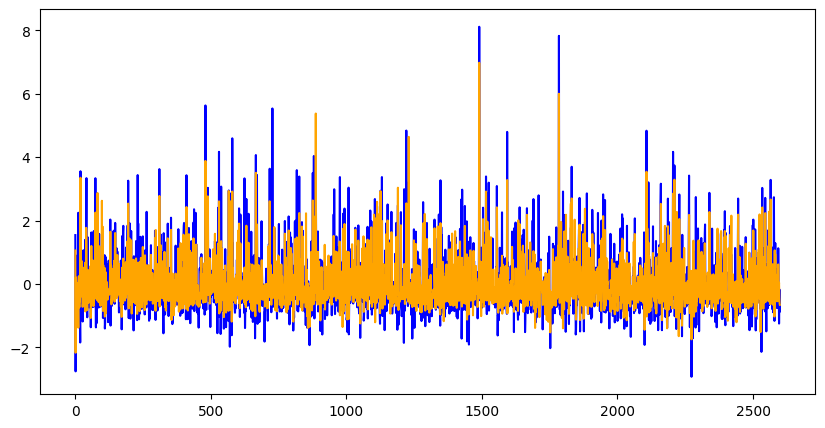

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(y_val, label='Real', color='blue')
plt.plot(results, label='Distilled', color='orange')
plt.show()

In [ ]:
r_t_val_2 = np.array(r_t_val)
r_t_val_2 = r_t_val_2.flatten()

In [45]:
resta_1 =   r_t_val_2- y_val
resta_2 = Rs_pred.cpu().detach().numpy().flatten() - y_val




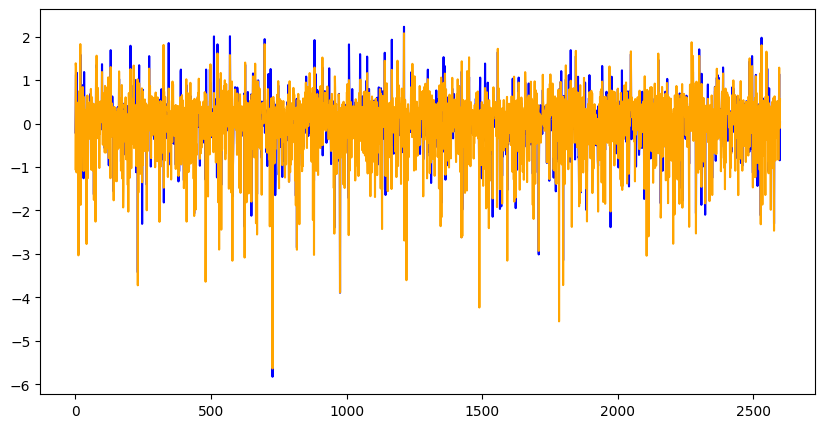

In [46]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(resta_1, label='Real', color='blue')
plt.plot(resta_2, label='Distilled', color='orange')
plt.show()

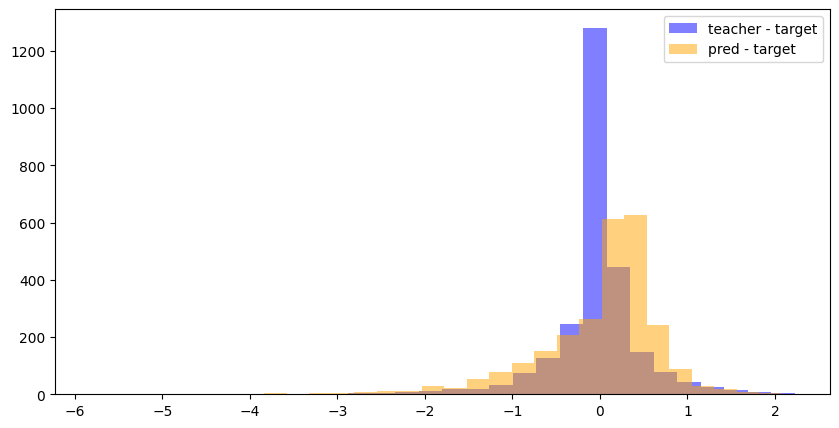

In [47]:
plt.figure(figsize=(10, 5))
plt.hist(resta_1, bins=30, alpha=0.5, label='teacher - target', color='blue')
plt.hist(resta_2, bins=30, alpha=0.5, label='pred - target', color='orange')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, results)
mae = mean_absolute_error(y_val, results)
smape_val = smape(y_val, results)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 0.34534402414096316
MSE: 0.32536526413996286
SMAPE: 32.66363319018094


In [15]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, r_t_val)
mae = mean_absolute_error(y_val, r_t_val)
smape_val = smape(y_val, r_t_val)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 0.29947147856463113
MSE: 0.2808381897192965
SMAPE: 67.40342706472372


In [36]:
# Con MSE
student = StudentODE_new()

student_trained = train_student_ode(
    student,
    X_train, y_train, r_t_train,
    X_val,   y_val,   r_t_val,
    batch_size=64,
    epochs=20,
    lr=0.001
)


Epoch 1/20 — Train Loss: 0.756612
Epoch 2/20 — Train Loss: 0.119886
Epoch 3/20 — Train Loss: 0.054834
Epoch 4/20 — Train Loss: 0.032431
Epoch 5/20 — Train Loss: 0.021789
Epoch 6/20 — Train Loss: 0.015651
Epoch 7/20 — Train Loss: 0.012021
Epoch 8/20 — Train Loss: 0.009737
Epoch 9/20 — Train Loss: 0.008053
Epoch 10/20 — Train Loss: 0.006832
Epoch 11/20 — Train Loss: 0.005880
Epoch 12/20 — Train Loss: 0.005135
Epoch 13/20 — Train Loss: 0.004494
Epoch 14/20 — Train Loss: 0.003960
Epoch 15/20 — Train Loss: 0.003507
Epoch 16/20 — Train Loss: 0.003114
Epoch 17/20 — Train Loss: 0.002759
Epoch 18/20 — Train Loss: 0.002449
Epoch 19/20 — Train Loss: 0.002167
Epoch 20/20 — Train Loss: 0.001918


In [37]:
student_trained.eval()
x_neural = torch.tensor(X_val, dtype=torch.float32)
Rs_pred, Rd_pred = student_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
# Rd_pred es tu salida distill, compárala con y_val:
results =  Rd_pred.cpu().detach().numpy().flatten()

In [38]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, results)
mae = mean_absolute_error(y_val, results)
smape_val = smape(y_val, results)

print("MAE:", mae)
print("MSE:", mse)
print("SMAPE:", smape_val)

MAE: 0.6712705854027053
MSE: 1.0221906002371073
SMAPE: 60.92083648345342
